In [223]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))


from utils import *

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

sns.set_style('ticks')

## 0. Read and inspect data files

In [224]:
input_path = '../Data/'

feature_file = 'Fingerprints/TopologicalTorsions_Fingerprints_Frequency_Size50.csv'
features_file_2 =  'leffingwell_features_96.npy'
CID_file = 'molecules_train_cid.npy'

# Read all copies, before and after correction; before was also downloaded from Dropbox.
mixture_file = 'Mixure_Definitions_Training_set_UPD2.csv' 
training_task_file = 'TrainingData_mixturedist.csv'

# Mordred features
features_1 = pd.read_csv(os.path.join(input_path, feature_file), index_col= 0)
features_2 = np.load(os.path.join(input_path, features_file_2))

features_CIDs = np.load(os.path.join(input_path, CID_file))

# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))

In [225]:
# Map CID to 96 dim features:
CID2features_morgan =  {CID: features_1.loc[CID].tolist() for CID in features_CIDs}
CID2features_leffingwell = {CID: features_2[i] for i, CID in enumerate(features_CIDs)}

In [226]:
X_m, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features_morgan, method = 'sum')
X_l, _, _, _ = format_Xy(training_set,  mixtures_IDs, CID2features_leffingwell, method = 'sum')

In [227]:
# Convert the input pairs to a suitable format for training
X_pairs_m = np.array([(np.concatenate((x1, x2))) for x1, x2 in X_m])
X_pairs_l = np.array([(np.concatenate((x1, x2))) for x1, x2 in X_l])

y_true = np.array(y)

In [228]:
distances_m = [get_euclidean_distance(m[0], m[1]) for m in X_m]
similarities_m = [get_cosine_similarity(m[0], m[1]) for m in X_m]
angles_m = [get_cosine_angle(m[0], m[1]) for m in X_m] 

distances_l = [get_euclidean_distance(m[0], m[1]) for m in X_l]
similarities_l = [get_cosine_similarity(m[0], m[1]) for m in X_l]
angles_l = [get_cosine_angle(m[0], m[1]) for m in X_l] 

In [229]:
shared_monos = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in all_pairs_CIDs]
diff_monos = [ len( set(pair[0]).difference(set(pair[1]))) for pair in all_pairs_CIDs]

In [230]:
datasets = training_set['Dataset'].to_numpy()
# Returns the uniques in the order of appearance
desired_order = training_set['Dataset'].unique().tolist() 
encoder = OneHotEncoder(categories=[desired_order])
data_arr = encoder.fit_transform(datasets.reshape(-1, 1))
data_arr = data_arr.toarray()

In [231]:
## add all information above
X_features = np.hstack( (X_pairs_l, X_pairs_m,
                        np.array(distances_m).reshape(500, 1), 
                        np.array(similarities_m).reshape(500, 1), 
                        np.array(angles_m).reshape(500, 1), 
                        np.array(distances_l).reshape(500, 1), 
                        np.array(similarities_l).reshape(500, 1), 
                        np.array(angles_l).reshape(500, 1), 
                        np.array(shared_monos).reshape(500, 1), 
                        np.array(diff_monos).reshape(500, 1), 
                        np.array(num_mixtures).reshape(500,2), 
                        data_arr))


In [232]:
feature_names = [f'Lw_dim{i}_1' for i in range(113)] +  [f'Lw_dim{i}_2' for i in range(113)] +  \
                [f'Mg_dim{i}_1' for i in range(50)] +  [f'Mg_dim{i}_2' for i in range(50)] + \
                ['dist_Mg', 'sim_Mg', 'angle_Mg', 'dist_Lw', 'sim_Lw', 'angle_Lw'] + \
                    ['shared_mono', 
                     'diff_mono', 
                     'num_mix1',
                     'num_mix2',
                     'snitz 1',
                     'snitz 2', 
                     'ravia', 
                     'bushdid'] 


### Correlation between combined mixture embeddings and eperimetal values

In [233]:
# dist_corr = np.corrcoef(distances_l, y_true)[0, 1]
dist_corr = np.corrcoef(distances_m, y_true)[0, 1]

print('R (Deepnose embedding Eucledian distance v.s Experimental Value): ', dist_corr)

R (Deepnose embedding Eucledian distance v.s Experimental Value):  0.3087873407547806


In [234]:
# sim_corr = np.corrcoef(similarities_l, y_true)[0, 1]
sim_corr = np.corrcoef(similarities_m, y_true)[0, 1]

print('R (Cosyne similarity v.s. Experimental Value): ', sim_corr)

R (Cosyne similarity v.s. Experimental Value):  -0.4139565707772965


In [235]:
# sim_corr = np.corrcoef(angles_l, y_true)[0, 1]
sim_corr = np.corrcoef(angles_m, y_true)[0, 1]

print('R (Vector angle v.s. Experimental Value): ', sim_corr)

R (Vector angle v.s. Experimental Value):  0.459082357958731


----
## 2. Training
### 2.1 Example attempt, standard intialized RF and XGBoost

In [236]:
n_folds = 10
# seed = 314159
seed = 0
best_rf = {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 30, 'bootstrap': True}
best_rgb = {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.5}

In [237]:
rf_pred_list = []
xgb_pred_list = []
kf_rf_importances = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_features):
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]
    
    # Train the Random Forest regressor
    # rf = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf_model = RandomForestRegressor(**best_rf, random_state=seed)

    rf_model.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    # xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=seed)
    xgb_model = xgb.XGBRegressor(**best_rgb, random_state=seed)

    xgb_model.fit(X_train, y_train)
    
    # Make predictions 
    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    importances = rf_model.feature_importances_
    kf_rf_importances.append(importances)
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_test)
    test_indices_list.extend(test_index)  # Store the test indices

# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)

In [238]:
training_set.head()

,Dataset,Mixture 1,Mixture 2,Experimental Values,rf_pred,xgb_pred,y_true
350,Snitz 1,1,2,0.604167,0.577547,0.584227,0.604167
0,Snitz 1,1,3,0.651042,0.670854,0.650991,0.651042
200,Snitz 1,1,5,0.505208,0.480489,0.471982,0.505208
300,Snitz 1,1,6,0.411458,0.521665,0.514858,0.411458
100,Snitz 1,1,7,0.562500,0.637044,0.619758,0.562500


In [239]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}") 
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")


Random Forest - R: 0.617
Random Forest - RMSE: 0.123

XGBoost - R: 0.610
XGBoost - RMSE: 0.124


#### Observations:

1. RF although in this example has a better score, tends to predict a safe value

2. prediction are correlated for the two methods, off ones are predicted off in the same way..

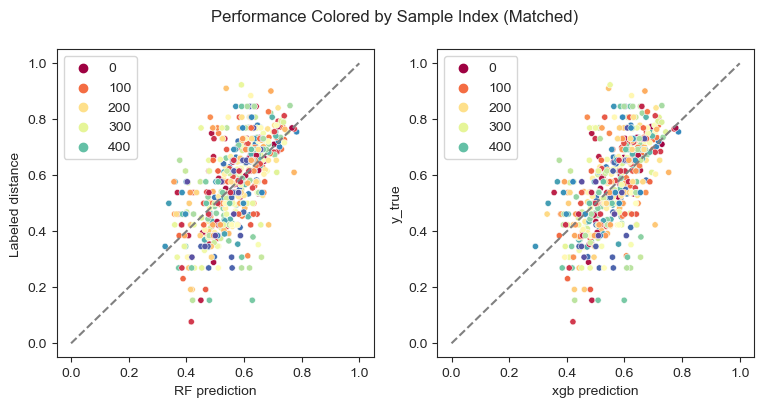

In [240]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = training_set.index, ax = ax[0], s = 20, palette= 'Spectral')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = training_set.index, ax = ax[1], s = 20, palette= 'Spectral')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Sample Index (Matched)')

plt.show()

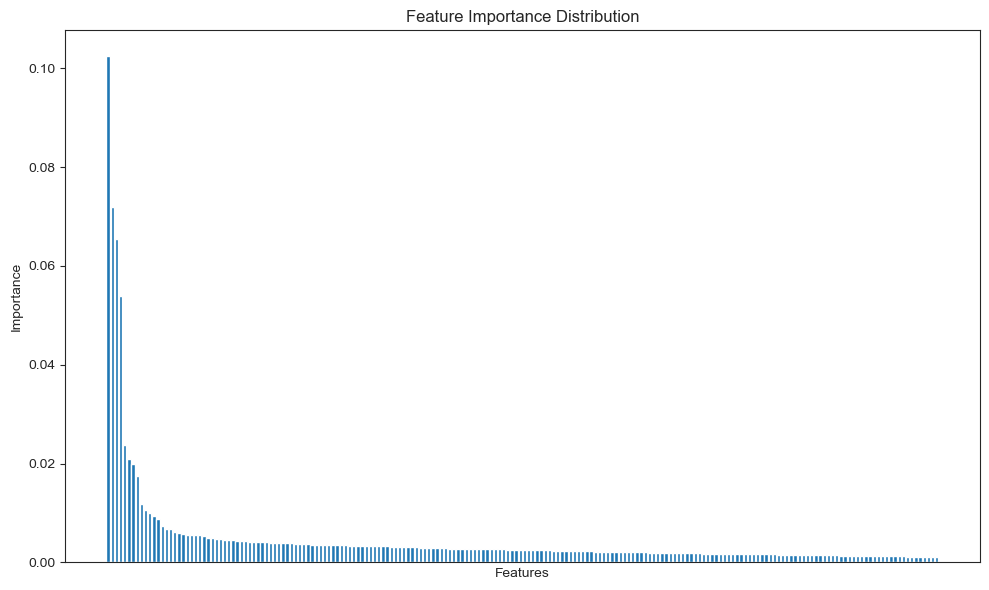

In [241]:
# Calculate the mean feature importances across all folds
mean_importances = np.mean(kf_rf_importances, axis=0)

# Sort the features by their mean importance
sorted_indices = np.argsort(mean_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = mean_importances[sorted_indices]

# Plot the feature importance distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features))[:200], sorted_importances[:200])
# plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.xticks([])

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Distribution')
plt.tight_layout()
plt.show()